In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
import re
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [2]:
df = pd.read_csv('data_book_clean.csv')

In [3]:
# Instanciamos el label encoder para aplicarselo a la clase que vamos a predecir: generos litearios
# Tambien si queremos encodear otras variables
le = preprocessing.LabelEncoder()

GENEROS LITERARIOS

In [4]:
# Filtrar losgeneros con menos de 100 libros publicados
df2 = df.groupby('genero_1').filter(lambda x: x['genero_1'].count()>100)

In [5]:
# Generos con mas de 100 libros
df2['genero_1'].value_counts()

ENSAYOS                     1159
INFANTILES                  1025
NOVELAS EXTRANJERAS         1002
NARRATIVA                    565
OBRAS DIVERSAS               502
NOVELAS ARGENTINAS           481
AUTOAYUDA                    393
BIOGRAFIAS                   283
NOVELA                       245
JUVENILES                    218
FICCION                      179
NOVELAS LATINOAMERICANAS     135
CUENTOS ARGENTINOS           127
Name: genero_1, dtype: int64

In [6]:
# Nos quedamos con 6314 casos
len(df2)

6314

In [7]:
# Reseteamos el indice del dataframe (despues de haber excluidos algunos generos)
df2.reset_index(inplace=True)

CANTIDAD DE LIBROS POR AUTOR

In [8]:
# Vemos cuantas veces aparece cada autor
autores = df2.groupby('autor')['autor'].count()

In [9]:
autores = autores.sort_values(ascending = False)

In [10]:
with pd.option_context('display.max_rows', 1500):
    print(autores)

autor
 Nik                                                                                                                                                                                                                                       127
 Chanti                                                                                                                                                                                                                                     74
Julio Cortázar                                                                                                                                                                                                                              63
Stephen King                                                                                                                                                                                                                                60
Danielle Steel                        

In [11]:
df_autcount = pd.DataFrame(autores)

In [12]:
df_autcount['nombres'] = df_autcount.index

In [13]:
# Vemos los valores unicos para las frecuencias de autores: hay autores que aparecen 127 veces, 74 veces, etc.
df_autcount['autor'].unique()

array([127,  74,  63,  60,  55,  54,  49,  42,  41,  39,  37,  35,  34,
        30,  29,  28,  26,  24,  23,  22,  21,  20,  19,  18,  17,  16,
        15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,
         2,   1], dtype=int64)

In [14]:
# Generar un DataFrame para identificar las veces exactas que aparece cada autor o grupo de autores y poder plotear

# Agrupo los autores
aut = df2.groupby('autor')['autor'].count()

# Genero el primer df
aut_count = pd.DataFrame(aut)

# Creo la columna 'nombres' de los autores
aut_count['nombres'] = aut_count.index

# Creo la columna 'veces' que aparece el autor
aut_count['veces'] = aut_count['autor']

# Borro la columna 'autor'
aut_count.drop(columns='autor', inplace=True)

# Seteo un indice numerico
aut_count.index = range(len(aut_count))

In [15]:
# Veo el DataFrame. Coincide con el anterior ('autores')
aut_count.sort_values('veces',ascending=False);

Text(0,0.5,'Cantidad de autores')

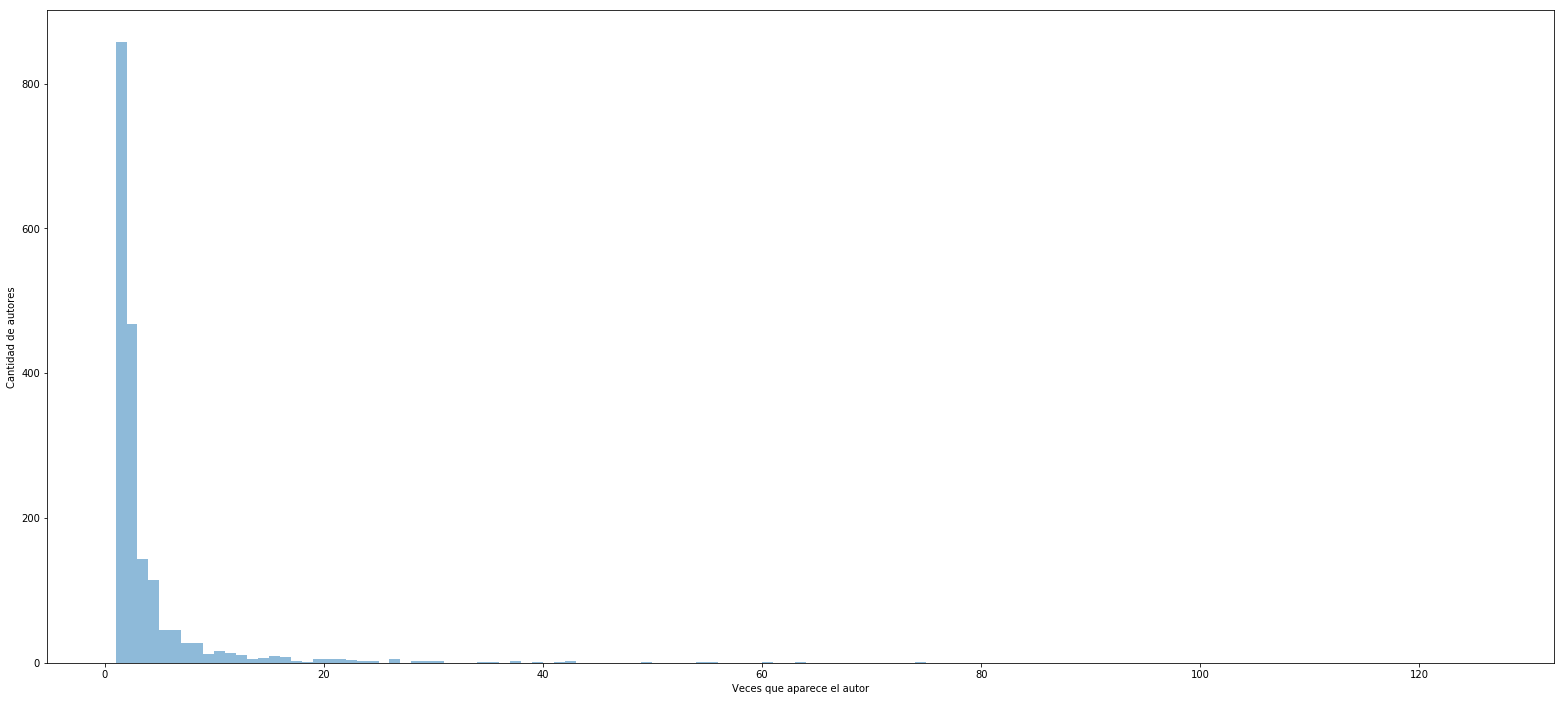

In [16]:
# Histograma de la distribucion de autores

bins = np.arange(aut_count['veces'].min(), aut_count['veces'].max())
plt.figure(figsize=(27,12))
plt.hist(aut_count['veces'], bins=bins, alpha = 0.5)
plt.xlabel('Veces que aparece el autor')
plt.ylabel('Cantidad de autores')

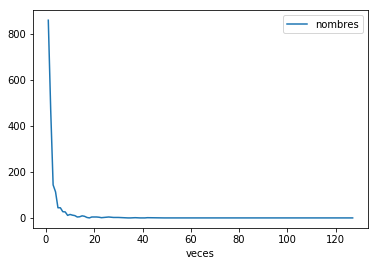

In [17]:
# La mayoria de los autores tienen entre 1 y 6 libros aproximadamente
aut_count.groupby('veces').count().plot()

In [18]:
# Hay 1867 autores
aut_count['nombres'].count()

1867

In [19]:
# Creo una funcion para categorizar las frecuencias en las que aparecen los autores

def categorizer(x):
    if 0 < x <= 6:
        return 'Entre 1 y 6 veces'
    elif 6 < x <= 127:
        return 'Mas de 6 veces'

In [20]:
# Aplico la funcion

aut_count['frecuencias'] = aut_count['veces'].apply(categorizer)

In [21]:
# De nuestro dataframe, el 10% de los autores tienen mas de seis libros publicados. En cambio, el 90% tiene entre 1 y 6 libros

aut_count.frecuencias.value_counts(normalize=True)

Entre 1 y 6 veces    0.896626
Mas de 6 veces       0.103374
Name: frecuencias, dtype: float64

In [22]:
# Creo una variable dummy para pasarle al modelo de clasificacion los nombres de los autores

df2['aut_dum'] = df2['autor']

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# Identifico a los autores mayoritarios (los que tienen menos de seis libros publicados)

autores_mayoritarios = aut_count.loc[aut_count['frecuencias'] == 'Entre 1 y 6 veces']

In [24]:
# Los apendeo en una lista para poder reemplazarlos en el DataFrame

aut_menos6 = []

for i in autores_mayoritarios['nombres']:
    aut_menos6.append(i)

In [25]:
# Chequeo cuantos son. Esta OK

len(aut_menos6)

1674

In [26]:
# Los reemplazo en el DataFrame

df2['aut_dum'].replace(aut_menos6,'otros', inplace=True)

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


FECHA DE PUBLICACION DE NOVEDAD

In [27]:
# Llamo el DataFrame de Juan porque en el de Rodri el formato de la fecha estaba cambiado
df3 = pd.read_csv('df_sinopsis.csv')

In [28]:
df4 = df3.groupby('genero_1').filter(lambda x: x['genero_1'].count()>100)

In [29]:
df4.reset_index(inplace=True)

In [30]:
# Genero una columna con la fecha corregida
df2['fecha_corr'] = df4['fecha_nov']

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [31]:
# Convierto a str la fecha para poder hacer slicing en los valores
df2['fecha_st'] = df2['fecha_corr'].astype(str)

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [32]:
# Creo las tres columnas de fecha
df2['year'] = df2['fecha_st'].str[0:4]
df2['mes'] = df2['fecha_st'].str[4:6]
df2['dia'] = df2['fecha_st'].str[6:8]

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [33]:
# Convierto en int la columna year
df2['year'] = df2['year'].astype('int64')

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
# Le paso un label encoder al mes para pasarlo a int
df2['mes_en'] = le.fit_transform(df2['mes'])

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [35]:
# Le paso un label encoder al dia para pasarlo a int
df2['dia_en'] = le.fit_transform(df2['dia'])

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


PUBLICACION DIGITAL

In [36]:
# Convertimos el feature digital en dummy
df2['digital'].fillna(0, inplace=True)

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [37]:
df2['digital'].unique()

array([0, 'X'], dtype=object)

In [38]:
df2['digital'].replace('X',1, inplace=True)

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [39]:
df2['digital'].unique()

array([0, 1], dtype=int64)

In [40]:
df2['digital'] = df2['digital'].astype('int64')

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


CODIGO DEL SELLO EDITORIAL

In [41]:
df2['sello_en'] = le.fit_transform(df2['cod_sello_editorial'])

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


DATAFRAME FINAL: Tiene los autores como dummies, el año/mes de publicacion y si es digital

In [42]:
df2['aut_dum'].replace(' Varios Autores', 'otros', inplace = True)

C:\Users\Federico\Anaconda2\envs\py36\lib\site-packages\pandas\core\generic.py:4619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [43]:
df_final = pd.get_dummies(df2,columns=['aut_dum'])

MODELO DE CLASIFICACION (CARTS)

In [44]:
# fiteamos el label encoder a los generos
le.fit(df_final['genero_1'])

LabelEncoder()

In [45]:
le.classes_

array(['AUTOAYUDA', 'BIOGRAFIAS', 'CUENTOS ARGENTINOS', 'ENSAYOS',
       'FICCION', 'INFANTILES', 'JUVENILES', 'NARRATIVA', 'NOVELA',
       'NOVELAS ARGENTINAS', 'NOVELAS EXTRANJERAS',
       'NOVELAS LATINOAMERICANAS', 'OBRAS DIVERSAS'], dtype=object)

In [46]:
# Transformamos
le.transform(df_final['genero_1'])

array([11,  3,  3, ...,  3,  8,  3], dtype=int64)

In [47]:
# Son 13 etiquetas a predecir
list(le.classes_)

['AUTOAYUDA',
 'BIOGRAFIAS',
 'CUENTOS ARGENTINOS',
 'ENSAYOS',
 'FICCION',
 'INFANTILES',
 'JUVENILES',
 'NARRATIVA',
 'NOVELA',
 'NOVELAS ARGENTINAS',
 'NOVELAS EXTRANJERAS',
 'NOVELAS LATINOAMERICANAS',
 'OBRAS DIVERSAS']

In [48]:
# Creamos la clase a predecir
y = le.transform(df_final['genero_1'])

In [49]:
y

array([11,  3,  3, ...,  3,  8,  3], dtype=int64)

In [50]:
X = df_final[['digital','cod_autor','cod_sello_editorial','pvp']]

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6314 entries, 0 to 6313
Data columns (total 4 columns):
digital                6314 non-null int64
cod_autor              6314 non-null float64
cod_sello_editorial    6314 non-null int64
pvp                    6314 non-null float64
dtypes: float64(2), int64(2)
memory usage: 197.4 KB


In [52]:
treeclf = DecisionTreeClassifier(max_depth=5, criterion='gini')
treeclf.fit(X, y)

print('CV_Score: ', np.mean(cross_val_score(treeclf, X, y)))

CV_Score:  0.33931107856


USANDO LAS FEATURES SIN TUNEAR EL MODELO ALCANZA UN SCORE DE 34% PARA PREDECIR 13 ETIQUETAS

In [53]:
# Generamos X2 con las nuevas features mejoradas (faltaria cod_sello encodeda)
X2 = []
for i in df_final:
    X2.append(i)

In [54]:
# Sacamos de X2 las columnas que no vamos a usar con una lista por comprension
X2 = [e for e in X2 if e not in ('index','Unnamed: 0','autor','cod_autor','cod_sello_editorial','coleccion','contratapa','fecha_nov','genero_1','idioma','isbn','matnr','medidas','paginas',
 'portada','region','sello_editorial','sinopsis','titulo','texto','normal','fecha_corr','fecha_st','mes','dia','dia_en')]

In [55]:
X2 = df_final[X2]

In [56]:
treeclf.fit(X2, y)

print('CV_Score: ', np.mean(cross_val_score(treeclf, X2, y)))

CV_Score:  0.364490185949


USANDO LAS FEATURES SIN TUNEAR EL MODELO ALCANZA UN SCORE DE 36%. MEJORA PERO POCO

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.3, random_state = 41)

In [59]:
treeclf.fit(X_train, y_train)
print('CV_Score: ', np.mean(cross_val_score(treeclf, X2, y)))

CV_Score:  0.364490185949


PRUEBA CON GRID SEARCH

In [60]:
PARAMETROS = {'max_depth':[1,2,3,4,5,6], 'max_features':[1,2,3,4], 
              'max_leaf_nodes':[5,6,7,8,9,10], 'min_samples_leaf':[1,2,3,4],
              'min_samples_split':[2,3,4]}

In [61]:
gs = GridSearchCV(treeclf, PARAMETROS, verbose=1 , n_jobs=-1)

In [62]:
gs.fit(X2, y)

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits


[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 960 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 2460 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 4560 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 5184 out of 5184 | elapsed:   57.8s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6], 'max_features': [1, 2, 3, 4], 'max_leaf_nodes': [5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [63]:
print(gs.best_estimator_)
print(gs.best_score_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=4, max_leaf_nodes=9, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
0.297592651251


CON GD NO MEJORA, ESTARE HACIENDO ALGO MAL?

In [64]:
# Importancia de los atributos
pd.DataFrame({'Atributo':X2.columns,
              'importancia':treeclf.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
4,sello_en,0.604199
1,pvp,0.245330
0,digital,0.094777
165,aut_dum_Pepe Muleiro,0.025279
197,aut_dum_otros,0.012726


In [65]:
# Calcular y mostrar la matriz de confusión
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(y, treeclf.predict(X2))

In [66]:
predicted_cols = ['pred_'+c for c in le.classes_]
pd.DataFrame(conf, index = le.classes_, columns = predicted_cols)

,pred_AUTOAYUDA,pred_BIOGRAFIAS,pred_CUENTOS ARGENTINOS,pred_ENSAYOS,pred_FICCION,pred_INFANTILES,pred_JUVENILES,pred_NARRATIVA,pred_NOVELA,pred_NOVELAS ARGENTINAS,pred_NOVELAS EXTRANJERAS,pred_NOVELAS LATINOAMERICANAS,pred_OBRAS DIVERSAS
AUTOAYUDA,116,0,0,47,0,1,0,0,5,2,222,0,0
BIOGRAFIAS,15,0,0,181,0,3,0,4,1,0,79,0,0
CUENTOS ARGENTINOS,12,0,0,21,0,6,2,7,0,21,56,0,2
ENSAYOS,55,0,0,828,0,10,0,6,1,11,246,0,2
FICCION,6,0,0,5,5,0,2,1,19,2,139,0,0
INFANTILES,0,0,0,94,0,782,1,0,12,0,136,0,0
JUVENILES,9,0,0,15,0,42,16,1,25,0,108,0,2
NARRATIVA,42,0,0,145,0,5,2,18,5,15,332,0,1
NOVELA,11,0,0,21,0,0,16,18,49,8,122,0,0
NOVELAS ARGENTINAS,63,0,0,109,0,2,3,14,5,85,198,0,2


PARA LOS QUE MAS CASOS HAY (ENSAYOS) PREDICE MEJOR, PERO TAMBIEN LE PIFIA MAS

### CORREGIMOS EL SELLO, EL TARGET Y AGREGAMOS EL FEATURE PAGINAS A UNA NUEVA PREDICCION

In [67]:
# Corregimos las editoriales
df_final['sello_editorial'].replace('DEBOLS!LLO','DEBOLSILLO', inplace=True)

In [68]:
df_final['sello_editorial'].replace(['ALFAGUARA I.' ,'ALFAGUARA J.', 'ALFAGUARA INFANTIL JUVENIL', 'CLARIN-ALFAGUARA'], ['ALFAGUARA','ALFAGUARA','ALFAGUARA','ALFAGUARA'], inplace=True)

In [69]:
df_final['sello_editorial'].replace(['SUDAMERICANA INFANTIL JUVENIL','SUDAMERICANA/ COPPPAL','SUDAMERICANA-EUDEBA'],['SUDAMERICANA','SUDAMERICANA','SUDAMERICANA'], inplace=True)

In [70]:
df_final['sello_editorial'].replace(['LITERATURA RANDOM HOUSE','ANAGRAMA & LITERATURA RANDOM HOUSE','PENGUIN RANDOM HOUSE','PENGUIN CLÁSICOS'],['RANDOM','RANDOM','RANDOM','RANDOM'], inplace=True)

In [71]:
df_final['sello_editorial'].replace('ORIGEN KIDS','ORIGEN', inplace = True)

In [72]:
# Se corrige el target (notebook Rodri)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('ENSAYO POLITICO', 'ENSAYOS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('ENSAYO RELIGIOSO', 'ENSAYOS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('NOVELAS CHILENAS', 'NOVELAS EXTRANJERAS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('NOVELAS LATINOAMERICANAS', 'NOVELAS EXTRANJERAS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('CUENTOS EXTRANJEROS', 'CUENTOS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('CUENTOS LATINOAMERICANOS', 'CUENTOS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('CUENTOS ARGENTINOS', 'CUENTOS', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('NARRATIVA BREVE', 'NARRATIVA', x['genero_1']), axis=1)
df_final['genero_1'] = df_final.apply(lambda x: re.sub('NARRATIVA FEMENINA', 'NARRATIVA', x['genero_1']), axis=1)

In [73]:
# Reemplazamos los null de las paginas por la moda
df_final.paginas.mode()

0    192.0
dtype: float64

In [74]:
df_final['paginas'].fillna(192, inplace=True)

In [75]:
# Preprocesamos el sello para la dummy (notebook Diego)
g = df_final.groupby('sello_editorial')
df_final.loc[g['sello_editorial'].transform(lambda x: len(x) < 100).astype(bool), 'sello_editorial'] = 'OTROS SELLOS'

In [76]:
# Nuevo DataFrame
df_final2 = pd.get_dummies(df_final,columns=['sello_editorial'])

In [77]:
# Nuevo target
y4 = le.fit_transform(df_final2['genero_1'])

In [78]:
# Lista para nuevas features
X4 = [e for e in df_final2 if e not in ('index','Unnamed: 0','autor','cod_autor','cod_sello_editorial','coleccion','contratapa','fecha_nov','genero_1','idioma','isbn','matnr','medidas',
 'portada','region','sello_editorial','sinopsis','titulo','texto','normal','fecha_corr','fecha_st','mes','dia','dia_en','sello_en')]

In [79]:
# Nuevas features
X4 = df_final2[X4]

In [80]:
# Grid search CV
kf = StratifiedKFold(n_splits=3, shuffle=True)


PARAMETROS = {#'max_features' : [1, 5, 10, 15, 20],
              'max_depth': [1,2,3,4,5,6,7], 
              'max_leaf_nodes' : [5,10,15,20,30], 
              'min_samples_leaf' : [1,2,3,4,5,10,15,20],
              'min_samples_split' : [5,6,7,8,9,10,20]}

#Se hace la búsqueda con Grid Search
arbol = DecisionTreeClassifier()
arbolgs = GridSearchCV(arbol, PARAMETROS, scoring='accuracy', cv=kf, verbose=1 , n_jobs=-1)
arbolgs.fit(X4, y4)

Fitting 3 folds for each of 1960 candidates, totalling 5880 fits


[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 653 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 1653 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 3053 tasks      | elapsed:   54.6s
[Parallel(n_jobs=-1)]: Done 4853 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 5873 out of 5880 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 5880 out of 5880 | elapsed:  1.9min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7], 'max_leaf_nodes': [5, 10, 15, 20, 30], 'min_samples_leaf': [1, 2, 3, 4, 5, 10, 15, 20], 'min_samples_split': [5, 6, 7, 8, 9, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [81]:
arbolgs.best_score_

0.55147291732657588

In [82]:
arbol_cv = arbolgs.best_estimator_
arbol_cv.fit(X4,y4)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=30,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

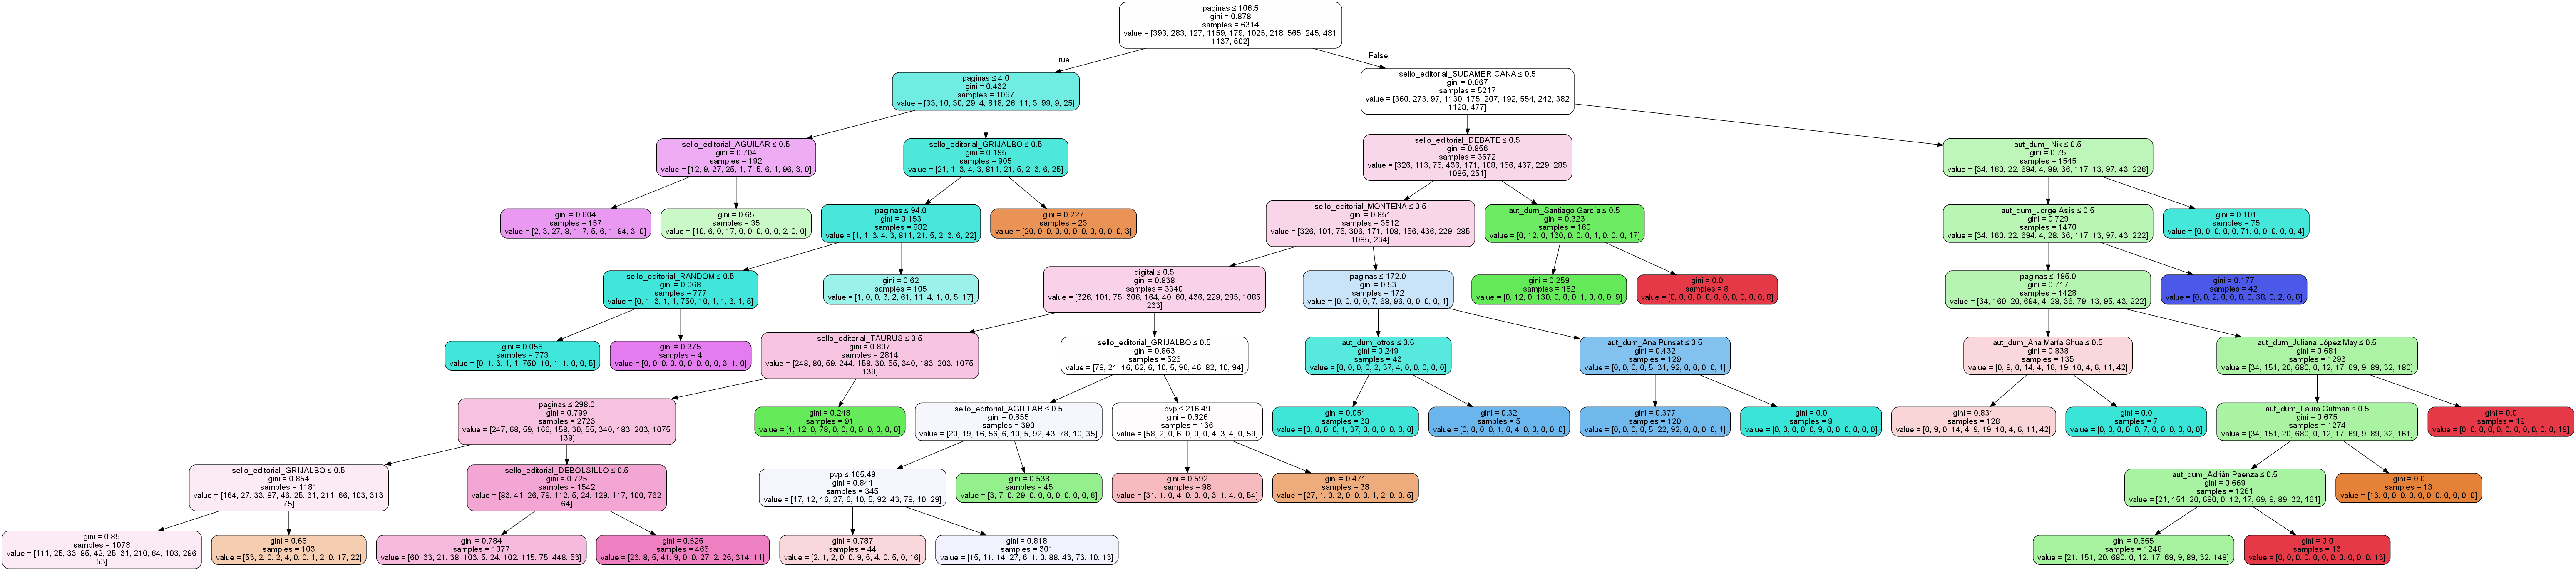

In [83]:
# Visualizacion del arbol

dot_data = export_graphviz(arbol_cv, out_file=None,  
                feature_names=X4.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [88]:
# Calcular la importancia de los atributos
pd.DataFrame({'Atributo':X4.columns,
              'importancia':arbol_cv.feature_importances_}).sort_values('importancia',
                                                                      ascending=False).head()

,Atributo,importancia
1,paginas,0.460919
212,sello_editorial_SUDAMERICANA,0.124639
201,sello_editorial_DEBATE,0.056788
206,sello_editorial_MONTENA,0.054526
203,sello_editorial_GRIJALBO,0.053678
